In [1]:
import time
import os
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from IPython import display

from dataset import Dataset
from gen_video import gen_video, gen_batched_img

Camera position mean & std:
[ -1.9723758  -11.407406     0.36299774] [10.950828   5.4356313 11.073948 ]
Camera position mean & std:
[ -0.97222143 -11.682014     0.6100528 ] [10.584989   5.2982874 11.329139 ]


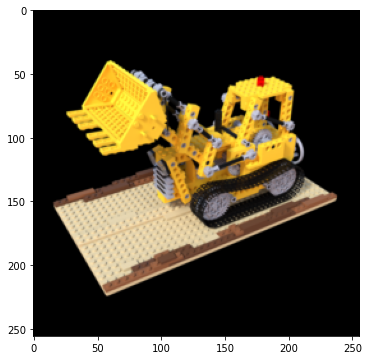

In [2]:
train_set = Dataset('../public/data/lego', 'blender', partition='train')
val_set = Dataset('../public/data/lego', 'blender', partition='val')
H, W = train_set.H, train_set.W

train_id = 68
val_id = 24

plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.imshow(train_set.images[train_id].permute(1,2,0))
#plt.subplot(122)
#plt.imshow(val_set.images[val_id].permute(1,2,0))
plt.show()

In [3]:
def ray_box_intersection(rays, bounds, zero_miss=True):
    """Find intersection of rays with a box
    
    Args:
        rays: Tensor with shape [None, 6]. Each row should be
            [x, y, z, dx, dy, dz]
        bounds: Tensor with shape [3, 2] representing
            min and max coords of the box on each axis
        zero_miss: Set coords to 0 for missed rays
    
    Returns size [None, 2, 3] tensor with nearest and furthest
        intersection coords rescaled to [0, 1]
        and a size [None,] hit mask
    """
    ro = rays[:, :3]
    rd = rays[:, 3:]
    bounds_expanded = bounds.unsqueeze(0).expand(rays.shape[0], 3, 2)
    signs = (rd < 0).long().unsqueeze(-1)
    near_bounds = bounds_expanded.gather(-1, signs).squeeze(-1)
    t_near = ((near_bounds - ro) / rd).max(dim=-1)[0]
    far_bounds = bounds_expanded.gather(-1, 1-signs).squeeze(-1)
    t_far = ((far_bounds - ro) / rd).min(dim=-1)[0]
    pts = torch.stack([
        ro + rd * t_near.unsqueeze(-1),
        ro + rd * t_far.unsqueeze(-1)
    ], dim=1)
    pts_rescaled = (pts - bounds[:, 0]) / (bounds[:, 1] - bounds[:, 0])
    hit_mask = t_near < t_far
    if zero_miss:
        pts_rescaled[~hit_mask] = 0
    return pts_rescaled, hit_mask

In [4]:
def gaussian(x, sigma):
    return torch.exp(-x**2 / (2 * sigma**2))

def lerp(a, b, t):
    return a * (1 - t) + b * t

In [5]:
class Model(nn.Module):
    def __init__(self, n_feats=256, n_layers=7):
        super().__init__()
        self.n_feats = n_feats
        
        layers = [nn.Linear(6, n_feats)] \
            + [nn.Linear(n_feats, n_feats) for _ in range(n_layers - 2)] \
            + [nn.Linear(n_feats, 3)]
        self.layers = nn.ModuleList(layers)
        
        self.bounds = torch.tensor([[-1,1],[-1,1],[-1,1]], device='cuda') * 8
        
        self.scene_points = torch.zeros(1, 3, device='cuda')
    
    def forward(self, rays, localization='origin'):
        local_rays = rays
        if localization == 'origin':
            # shift origins along ray so they're closest to 0,0,0
            ray_origins = rays[:, :3].repeat_interleave(self.scene_points.shape[0], dim=0)
            dirs_repeat = rays[:, 3:].repeat_interleave(self.scene_points.shape[0], dim=0)
            scene_points = self.scene_points.repeat(rays.shape[0], 1)
            ro_to_points = scene_points - ray_origins
            t = (ro_to_points * dirs_repeat).sum(dim=-1, keepdim=True)
            local_ro = ray_origins + dirs_repeat * t
            local_ro = local_ro.reshape(rays.shape[0], -1)
            # scale to object size
            local_ro = local_ro / 8
            local_rays = torch.cat([local_ro, rays[:, 3:]], dim=-1)
        elif localization == 'cube':
            pts, mask = ray_box_intersection(rays, self.bounds)
            # todo: handle missed rays
            local_rays = pts.reshape(pts.shape[0], -1)
        
        h = local_rays

        for i, layer in enumerate(self.layers[:-1]):
            h = layer(h)
            h = gaussian(h, lerp(0.3, 0.05, i / (len(self.layers) - 2)))
        
        y = self.layers[-1](h)
        
        return y

model = Model()
model.cuda()

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer,
#    lambda epoch: max(0.8 ** epoch, 0.1))
train_losses = [0]
val_losses = [0]

3000/3000
1m47s - eta 0s


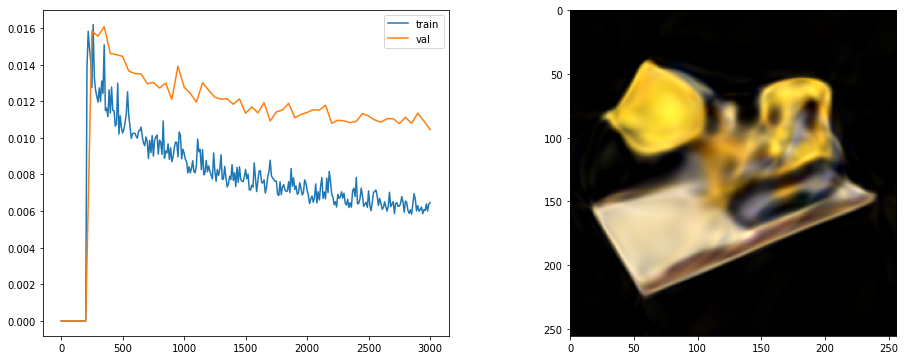

training loss: 0.006150896893814206
validation loss: 0.010933581180870533


In [6]:
train_st = time.time()
time_to_s = lambda t: (f'{int(t / 60)}m' if t >= 60 else '') + f'{int(t) % 60}s'

train_loss_freq = 10
val_loss_freq = 50
val_batch_size = int(4e4)

n_iter = int(3e3)
#n_iter = int(1e9)
batch_size = int(4e4)

while True:
    model_id = str(np.random.randint(1e6)) + '_tmp'
    if model_id not in os.listdir('models'):
        break
os.makedirs(f'models/{model_id}')

for i in range(n_iter):
    sel = np.random.choice(train_set.rays.shape[0], batch_size)
    pred = model(train_set.rays[sel])
    loss = loss_fn(pred, train_set.colors[sel])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (i + 1) % train_loss_freq == 0:
        if len(train_losses) <= 20:
            # cut off high end
            train_losses.append(0)
        else:
            train_losses.append(loss.item())
    if (i + 1) % val_loss_freq == 0:
        if len(train_losses) == 0 or train_losses[-1] == 0:
            val_losses.append(0)
        else:
            with torch.no_grad():
                sel = np.random.choice(val_set.rays.shape[0], val_batch_size)
                pred = model(val_set.rays[sel])
                loss = loss_fn(pred, val_set.colors[sel])
                val_losses.append(loss.item())
    if (i + 1) % 200 == 0:
        display.clear_output(wait=True)
        print(f'{i+1}/{n_iter}')
        time_passed = time.time() - train_st
        eta = time_passed * (n_iter - i) / i
        print(f'{time_to_s(time_passed)} - eta {time_to_s(eta)}')
        plt.figure(figsize=(16, 6))
        plt.subplot(121)
        plt.plot(np.arange(len(train_losses)) * train_loss_freq, train_losses, label='train')
        plt.plot(np.arange(len(val_losses)) * val_loss_freq, val_losses, label='val')
        plt.legend()
        plt.subplot(122)
        with torch.no_grad():
            pred = gen_batched_img(model,
                train_set.rays[train_id * H * W : (train_id + 1) * H * W], batch_size)
            plt.imshow(pred.detach().clip(0,1).reshape(H, W, 3).cpu())
        plt.show()
        print(f'training loss: {np.mean(train_losses[-10:])}')
        print(f'validation loss: {np.mean(val_losses[-10:])}')
    if (i + 1) % 1000 == 0:
        #scheduler.step()
        torch.save(model, f'models/{model_id}/model_{model_id}.pt')
        pass

In [7]:
gen_video(train_set, model, 'videos/out.mp4', batch_size=256**2)
display.clear_output()
display.display(display.HTML('<video src="videos/out.mp4" controls=true autoplay=true loop=true />'))